In [2]:
from preprocess import merge_parquets, sample_dat
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
import pandas as pd 
import os
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
dir = '../data'
dat = merge_parquets(dir)

In [4]:
sampled_dat = sample_dat(dat, 0.3)

In [5]:
del dat 

## Temporal Patterns in the taxi fare

Can we find a temporal patterns in the taxi fare?

In [5]:
sampled_dat = sampled_dat[sampled_dat['fare_amount'] > 0]
sampled_dat.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
2196845,2,2023-06-21 11:27:51,2023-06-21 11:33:14,1.0,0.75,1.0,N,239,142,1,7.2,0.0,0.5,1.50,0.0,1.0,12.70,2.5,0.0
893215,2,2023-03-09 11:14:49,2023-03-09 11:40:43,2.0,11.62,1.0,N,70,198,1,47.1,0.0,0.5,9.72,0.0,1.0,58.32,0.0,0.0
1260853,2,2023-07-15 18:33:53,2023-07-15 18:46:39,1.0,2.26,1.0,N,164,141,1,14.2,0.0,0.5,2.00,0.0,1.0,20.20,2.5,0.0
2462490,1,2023-05-22 16:22:30,2023-05-22 16:27:13,1.0,0.20,1.0,N,236,236,2,5.1,5.0,0.5,0.00,0.0,1.0,11.60,2.5,0.0
865511,1,2023-03-09 00:36:20,2023-03-09 01:14:18,1.0,9.30,1.0,N,68,228,1,39.4,3.5,0.5,8.85,0.0,1.0,53.25,2.5,0.0


In [6]:
def extract_dt(date):
    """
    return month, hour, weekday of a date field 
    """
    month = date.dt.month
    hour = date.dt.hour 
    weekname = date.dt.day_name() 
    date = date.dt.date

    return date, month, hour,  weekname 

def split_hours(hour):
    conditions = [
    (hour >= 6) & (hour < 10),
    (hour >= 10) & (hour< 16),
    (hour >= 16) & (hour < 20),
    (hour >= 20) | (hour < 6)
]
    choices = ['1.Morning (6am-10am)', '2.Midday (10am - 4pm)', '3.Evening Rush (4pm - 7pm)', '4.Night (8pm - 5am)']
    return np.select(conditions, choices)

sampled_dat['tpep_date'], sampled_dat['tpep_month'] , sampled_dat['tpep_hour'], sampled_dat['tpep_dayname'] = extract_dt(sampled_dat['tpep_pickup_datetime'])
sampled_dat['tpep_drop_date'], sampled_dat['tpep_drop_month'] , sampled_dat['tpep_drop_hour'], sampled_dat['tpep_drop_dayname'] = extract_dt(sampled_dat['tpep_dropoff_datetime'])
sampled_dat['time_of_day'] = split_hours(sampled_dat['tpep_hour'])



/var/folders/x0/rpxk2qtn1plg19j8v45ncgb80000gn/T/ipykernel_3358/678126656.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x= xvar, y= yvar, data = dat, palette='Set3')


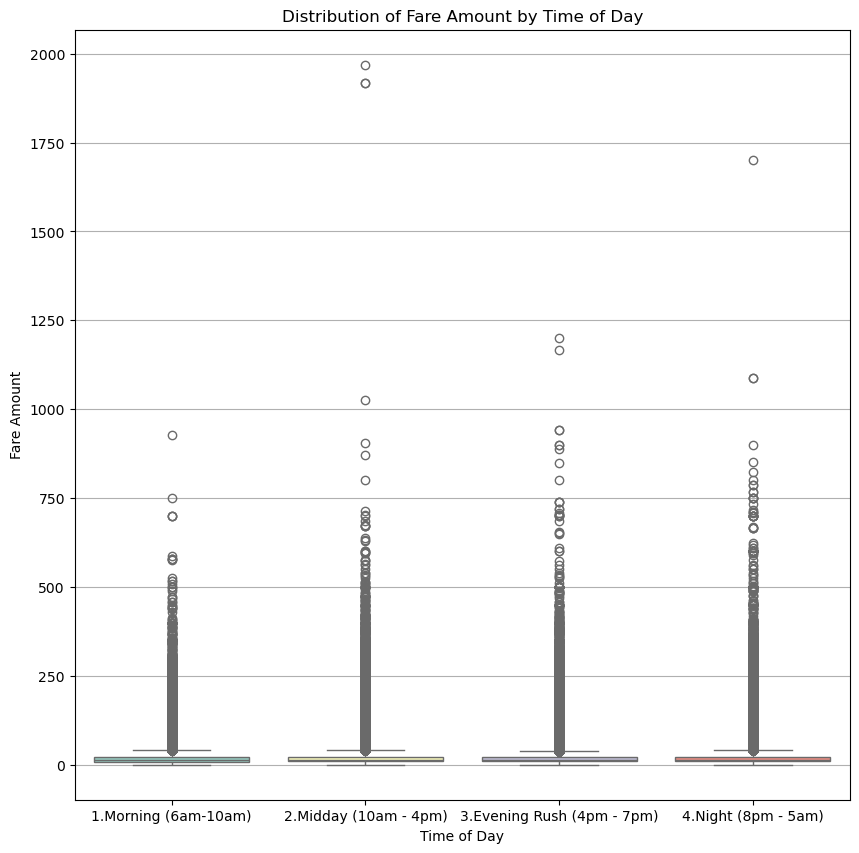

In [10]:
def boxplot(dat, xvar, yvar, title, xlabel, ylabel):
    plt.figure(figsize = (10,10))
    sns.boxplot(x= xvar, y= yvar, data = dat, palette='Set3')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis = 'y')
    plt.show()

sampled_dat = sampled_dat[(sampled_dat['fare_amount'] < 2000) & (sampled_dat['fare_amount'] > 0)]
boxplot(dat=sampled_dat, title = 'Distribution of Fare Amount by Time of Day', xvar = 'time_of_day', yvar = 'fare_amount', xlabel='Time of Day', ylabel='Fare Amount')


/var/folders/x0/rpxk2qtn1plg19j8v45ncgb80000gn/T/ipykernel_4559/1783574414.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time_of_day', y='fare_amount', data=sampled_dat, palette='Set3')


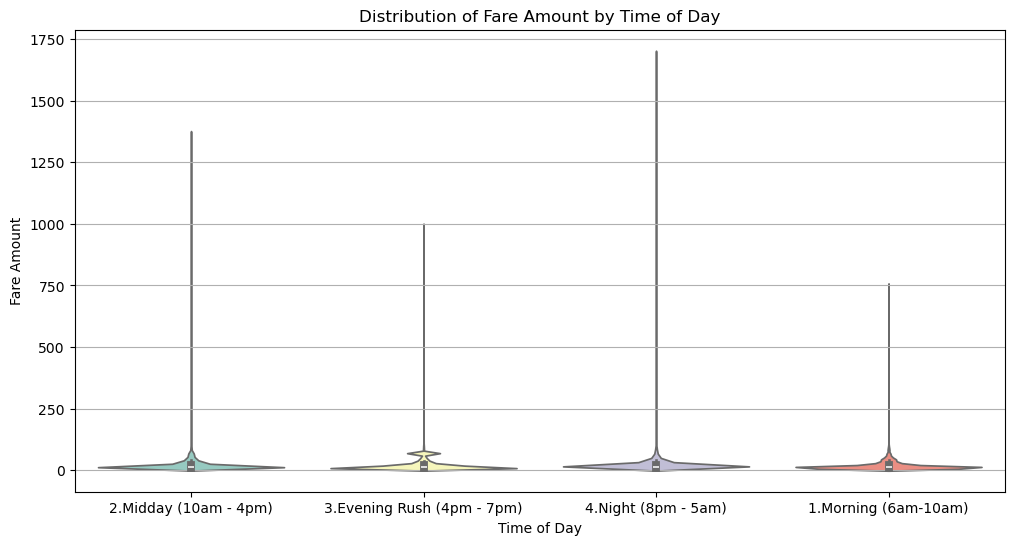

/var/folders/x0/rpxk2qtn1plg19j8v45ncgb80000gn/T/ipykernel_4559/1783574414.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time_of_day', y='fare_amount', data=sampled_dat, palette='Set3')


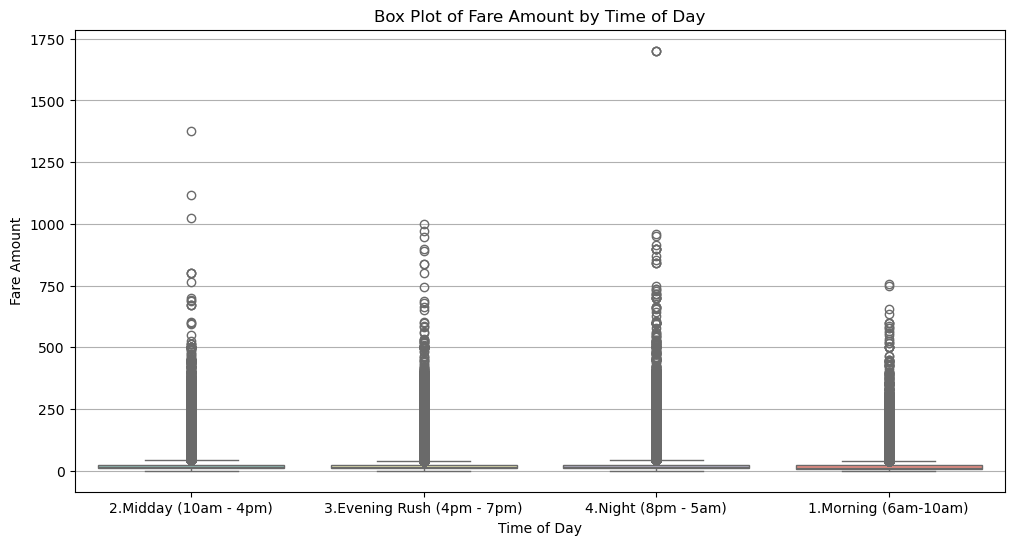

In [137]:
# Assuming 'sampled_dat' DataFrame already contains the 'time_of_day' and 'fare_amount' columns
sampled_dat = sampled_dat[(sampled_dat['fare_amount'] < 2000) & (sampled_dat['fare_amount'] > 0)]
# Create a violin plot for the distribution of fare amount by time of day
plt.figure(figsize=(12, 6))
sns.violinplot(x='time_of_day', y='fare_amount', data=sampled_dat, palette='Set3')
plt.title('Distribution of Fare Amount by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Fare Amount')
plt.grid(axis='y')
plt.show()

# Alternatively, create a box plot for more statistical insight
plt.figure(figsize=(12, 6))
sns.boxplot(x='time_of_day', y='fare_amount', data=sampled_dat, palette='Set3')
plt.title('Box Plot of Fare Amount by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Fare Amount')
plt.grid(axis='y')
plt.show()

In [1]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='tpep_dayname', y='fare_amount', data=sampled_dat, palette='Set3')
plt.title('Distribution of Fare Amount by Day')
plt.xlabel('Time of Day')
plt.ylabel('Fare Amount')
plt.grid(axis='y')
plt.show()

# Alternatively, create a box plot for more statistical insight
plt.figure(figsize=(12, 6))
sns.boxplot(x='tpep_dayname', y='fare_amount', data=sampled_dat, palette='Set3')
plt.title('Box Plot of Fare Amount by Day')
plt.xlabel('Time of Day')
plt.ylabel('Fare Amount')
plt.grid(axis='y')
plt.show()

NameError: name 'plt' is not defined

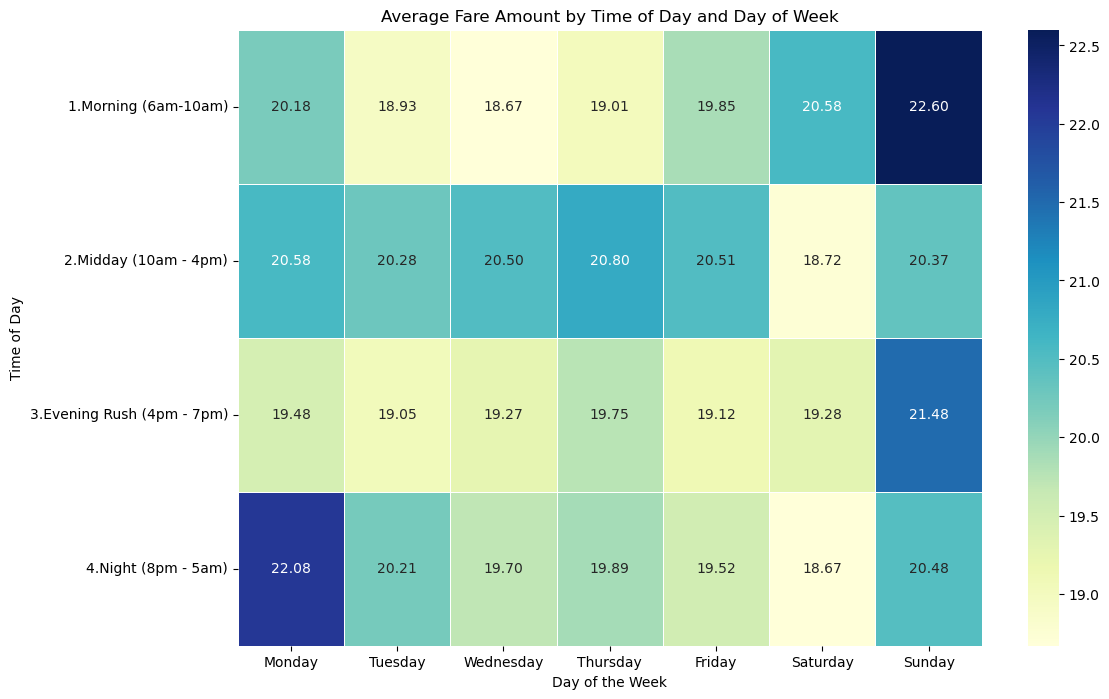

In [187]:
## Sunday morning - going to Airport?  - No, the proportion of airport trips on Sunday mornings was one of the lowest of all time blocks
# sampled_dat[sampled_dat['Airport_fee'] > 0].groupby(['time_of_day', 'tpep_dayname'])['Airport_fee'].count().unstack()  / sampled_dat.groupby(['time_of_day', 'tpep_dayname'])['Airport_fee'].count().unstack().sum(axis = 0)
## 
heatmap_data = sampled_dat.groupby(['time_of_day', 'tpep_dayname'])['fare_amount'].mean().unstack()

# Sort the day columns in order (if necessary)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data[day_order]

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title('Average Fare Amount by Time of Day and Day of Week')
plt.xlabel('Day of the Week')
plt.ylabel('Time of Day')
plt.show()

In [120]:
## checking for errorneous fare amounts
def remove_outliers(group, column):
    Q1 = group[column].quantile(0.25)
    Q3 = group[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group[column] >= lower_bound) & 
                 (group[column] <= upper_bound)]

sampled_dat['time_duration_in_mins'] = (sampled_dat['tpep_dropoff_datetime'] - sampled_dat['tpep_pickup_datetime']).dt.seconds // 60
sampled_dat['trip_distance_round'] = np.floor(sampled_dat['trip_distance'])

sampled_dat2 = sampled_dat.groupby('trip_distance_round', group_keys=False).apply(lambda group: remove_outliers(group, 'total_amount'))
sampled_dat2 = sampled_dat2.groupby('trip_distance_round', group_keys=False).apply(lambda group: remove_outliers(group, 'time_duration_in_mins'))
sampled_dat2 = sampled_dat2.groupby('time_duration_in_mins', group_keys=False).apply(lambda group: remove_outliers(group, 'trip_distance_round'))



/var/folders/x0/rpxk2qtn1plg19j8v45ncgb80000gn/T/ipykernel_3358/3587774554.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_dat2 = sampled_dat.groupby('trip_distance_round', group_keys=False).apply(lambda group: remove_outliers(group, 'total_amount'))
/var/folders/x0/rpxk2qtn1plg19j8v45ncgb80000gn/T/ipykernel_3358/3587774554.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_dat2 = sam

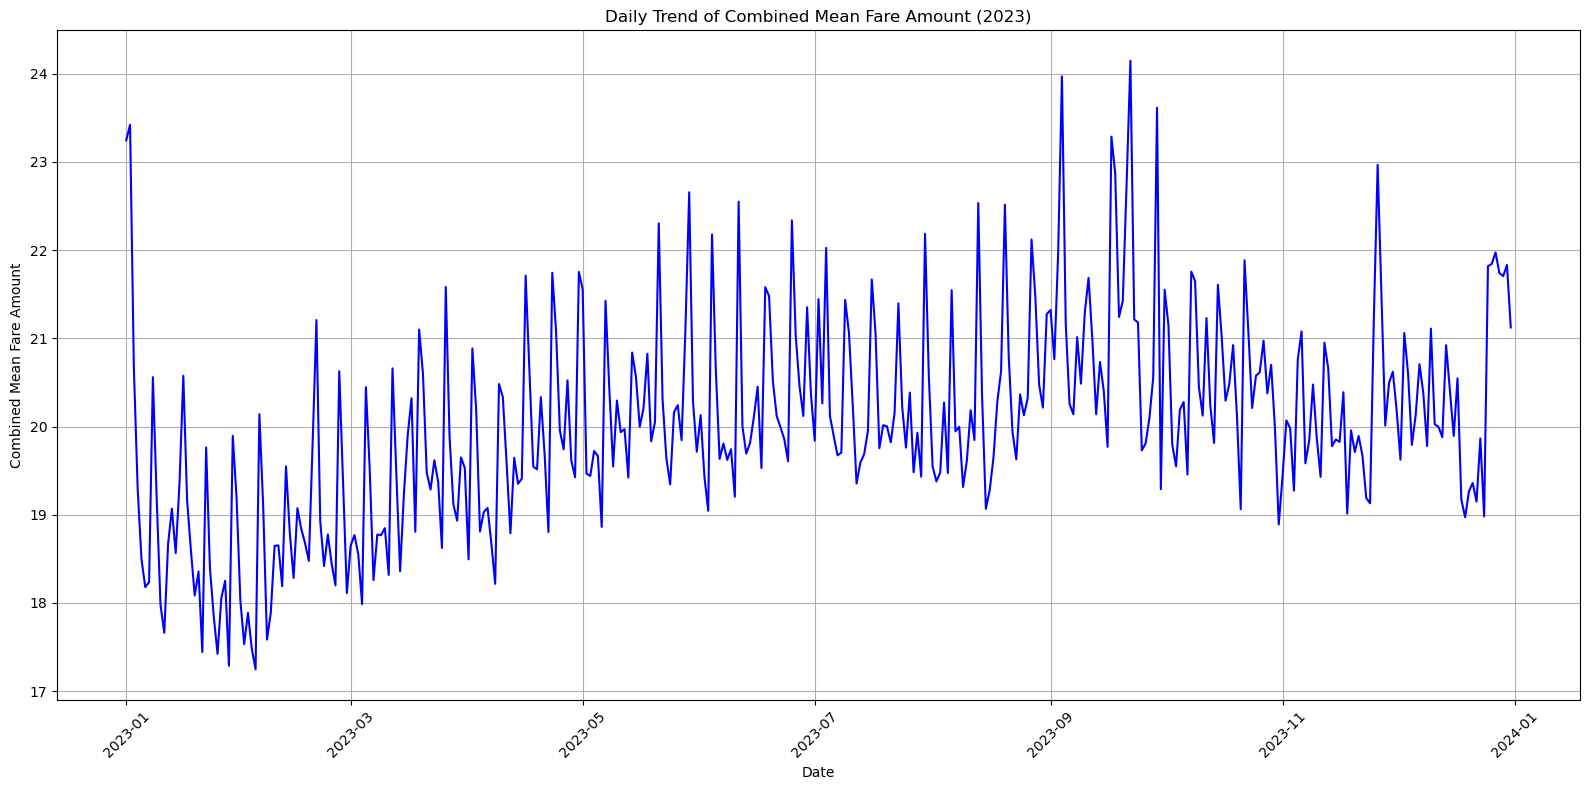

In [17]:
def lineplot(x, y, title, xlabel, ylabel):
    """
    
    """
    plt.figure(figsize=(16, 8))
    plt.plot(x,y, color = 'blue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(rotation =45)
    plt.tight_layout()
    plt.show()
daily_mean_fare = sampled_dat[sampled_dat['tpep_pickup_datetime'].dt.year == 2023].groupby(['tpep_date', 'time_of_day'])['fare_amount'].mean().reset_index()
daily_combined_mean_fare = daily_mean_fare.groupby('tpep_date')['fare_amount'].mean().reset_index()
lineplot(daily_combined_mean_fare['tpep_date'], daily_combined_mean_fare['fare_amount'], title = 'Daily Trend of Combined Mean Fare Amount (2023)',
xlabel = 'Date', ylabel = 'Combined Mean Fare Amount')


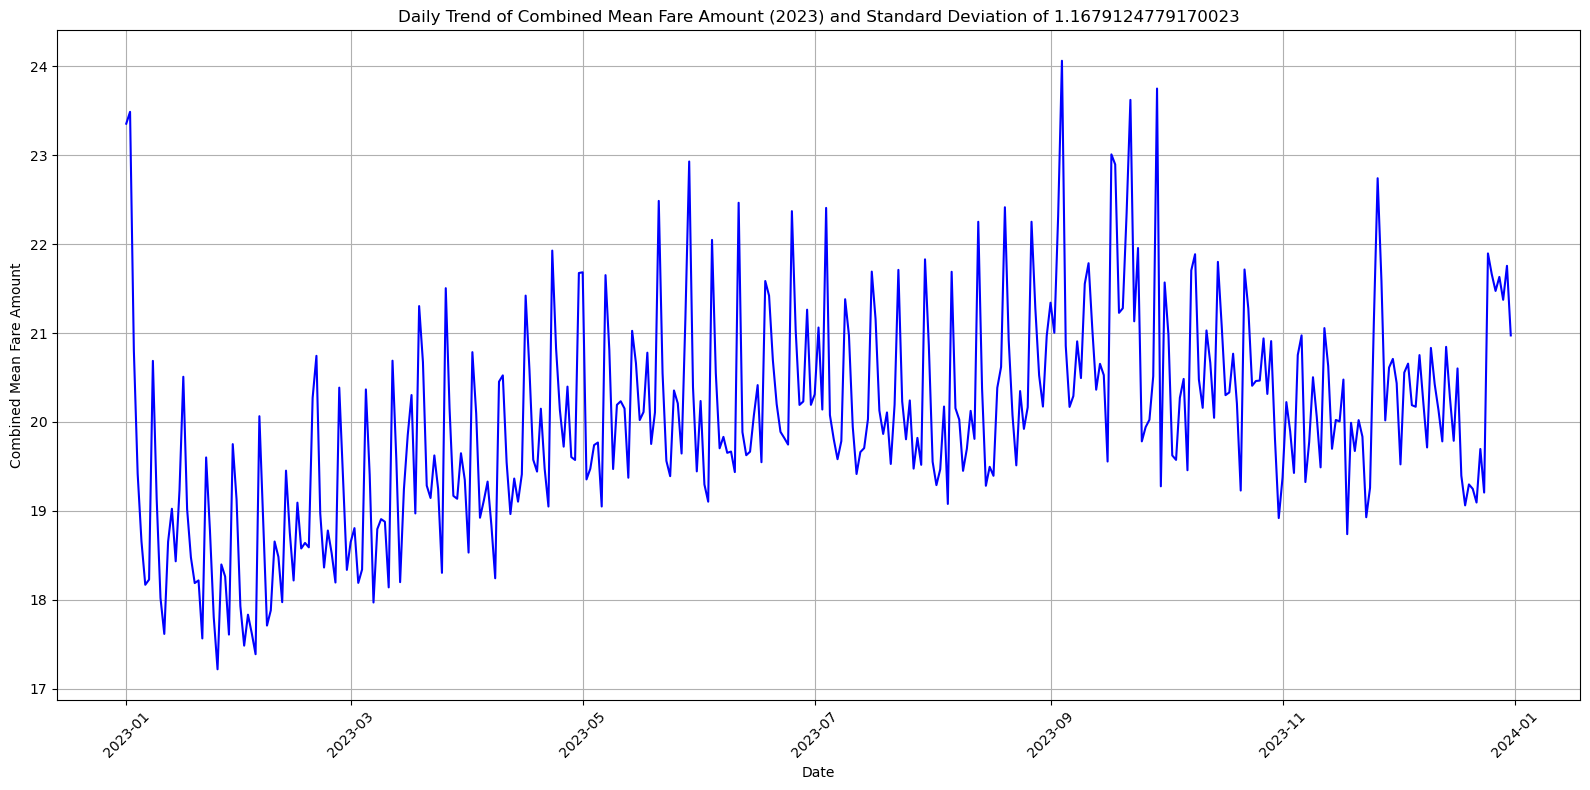

In [163]:
# Group by date and time_of_day, calculate mean fare amount
daily_mean_fare = sampled_dat[sampled_dat['tpep_pickup_datetime'].dt.year == 2023].groupby(['tpep_date', 'time_of_day'])['fare_amount'].mean().reset_index()

# Group by date again to get the mean of all time blocks for each day
daily_combined_mean_fare = daily_mean_fare.groupby('tpep_date')['fare_amount'].mean().reset_index()
std = np.std(daily_combined_mean_fare['fare_amount'])
# Plot the single trend line over the year
plt.figure(figsize=(16, 8))
plt.plot(daily_combined_mean_fare['tpep_date'], daily_combined_mean_fare['fare_amount'], label='Daily Combined Mean Fare', color='blue')

plt.title(f'Daily Trend of Combined Mean Fare Amount (2023) and Standard Deviation of {std}')
plt.xlabel('Date')
plt.ylabel('Combined Mean Fare Amount')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x1300 with 0 Axes>

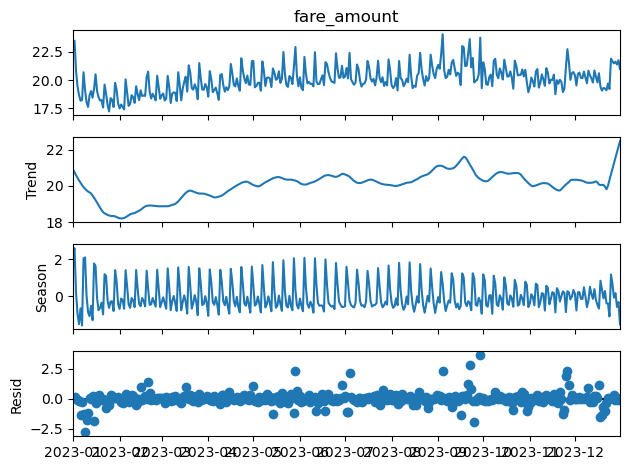

In [164]:
def decompose(dat, column):
    dat[column] = pd.to_datetime(dat[column])
    dat.set_index(column, inplace = True)
    result = stl.fit()
    plt.figure(figsize = (10,13))
    result.plot()
    plt.show()
    return result.seasonal


total_seasonal = decompose(daily_combined_mean_fare, 'tpep_date')

In [165]:
total_seasonal[:30]

tpep_date
2023-01-01    2.359480
2023-01-02    2.599984
2023-01-03    0.206822
2023-01-04   -0.938685
2023-01-05   -1.492471
2023-01-06   -0.640166
2023-01-07   -1.559510
2023-01-08    2.056547
2023-01-09    2.100083
2023-01-10    0.042906
2023-01-11   -0.850657
2023-01-12   -1.062626
2023-01-13   -0.501736
2023-01-14   -1.276991
2023-01-15    1.777024
2023-01-16    1.633440
2023-01-17   -0.095162
2023-01-18   -0.736188
2023-01-19   -0.620915
2023-01-20   -0.336610
2023-01-21   -0.962458
2023-01-22    1.200069
2023-01-23    1.106059
2023-01-24   -0.229613
2023-01-25   -0.616964
2023-01-26   -0.269405
2023-01-27   -0.264483
2023-01-28   -0.783666
2023-01-29    1.416710
2023-01-30    0.812919
Name: season, dtype: float64

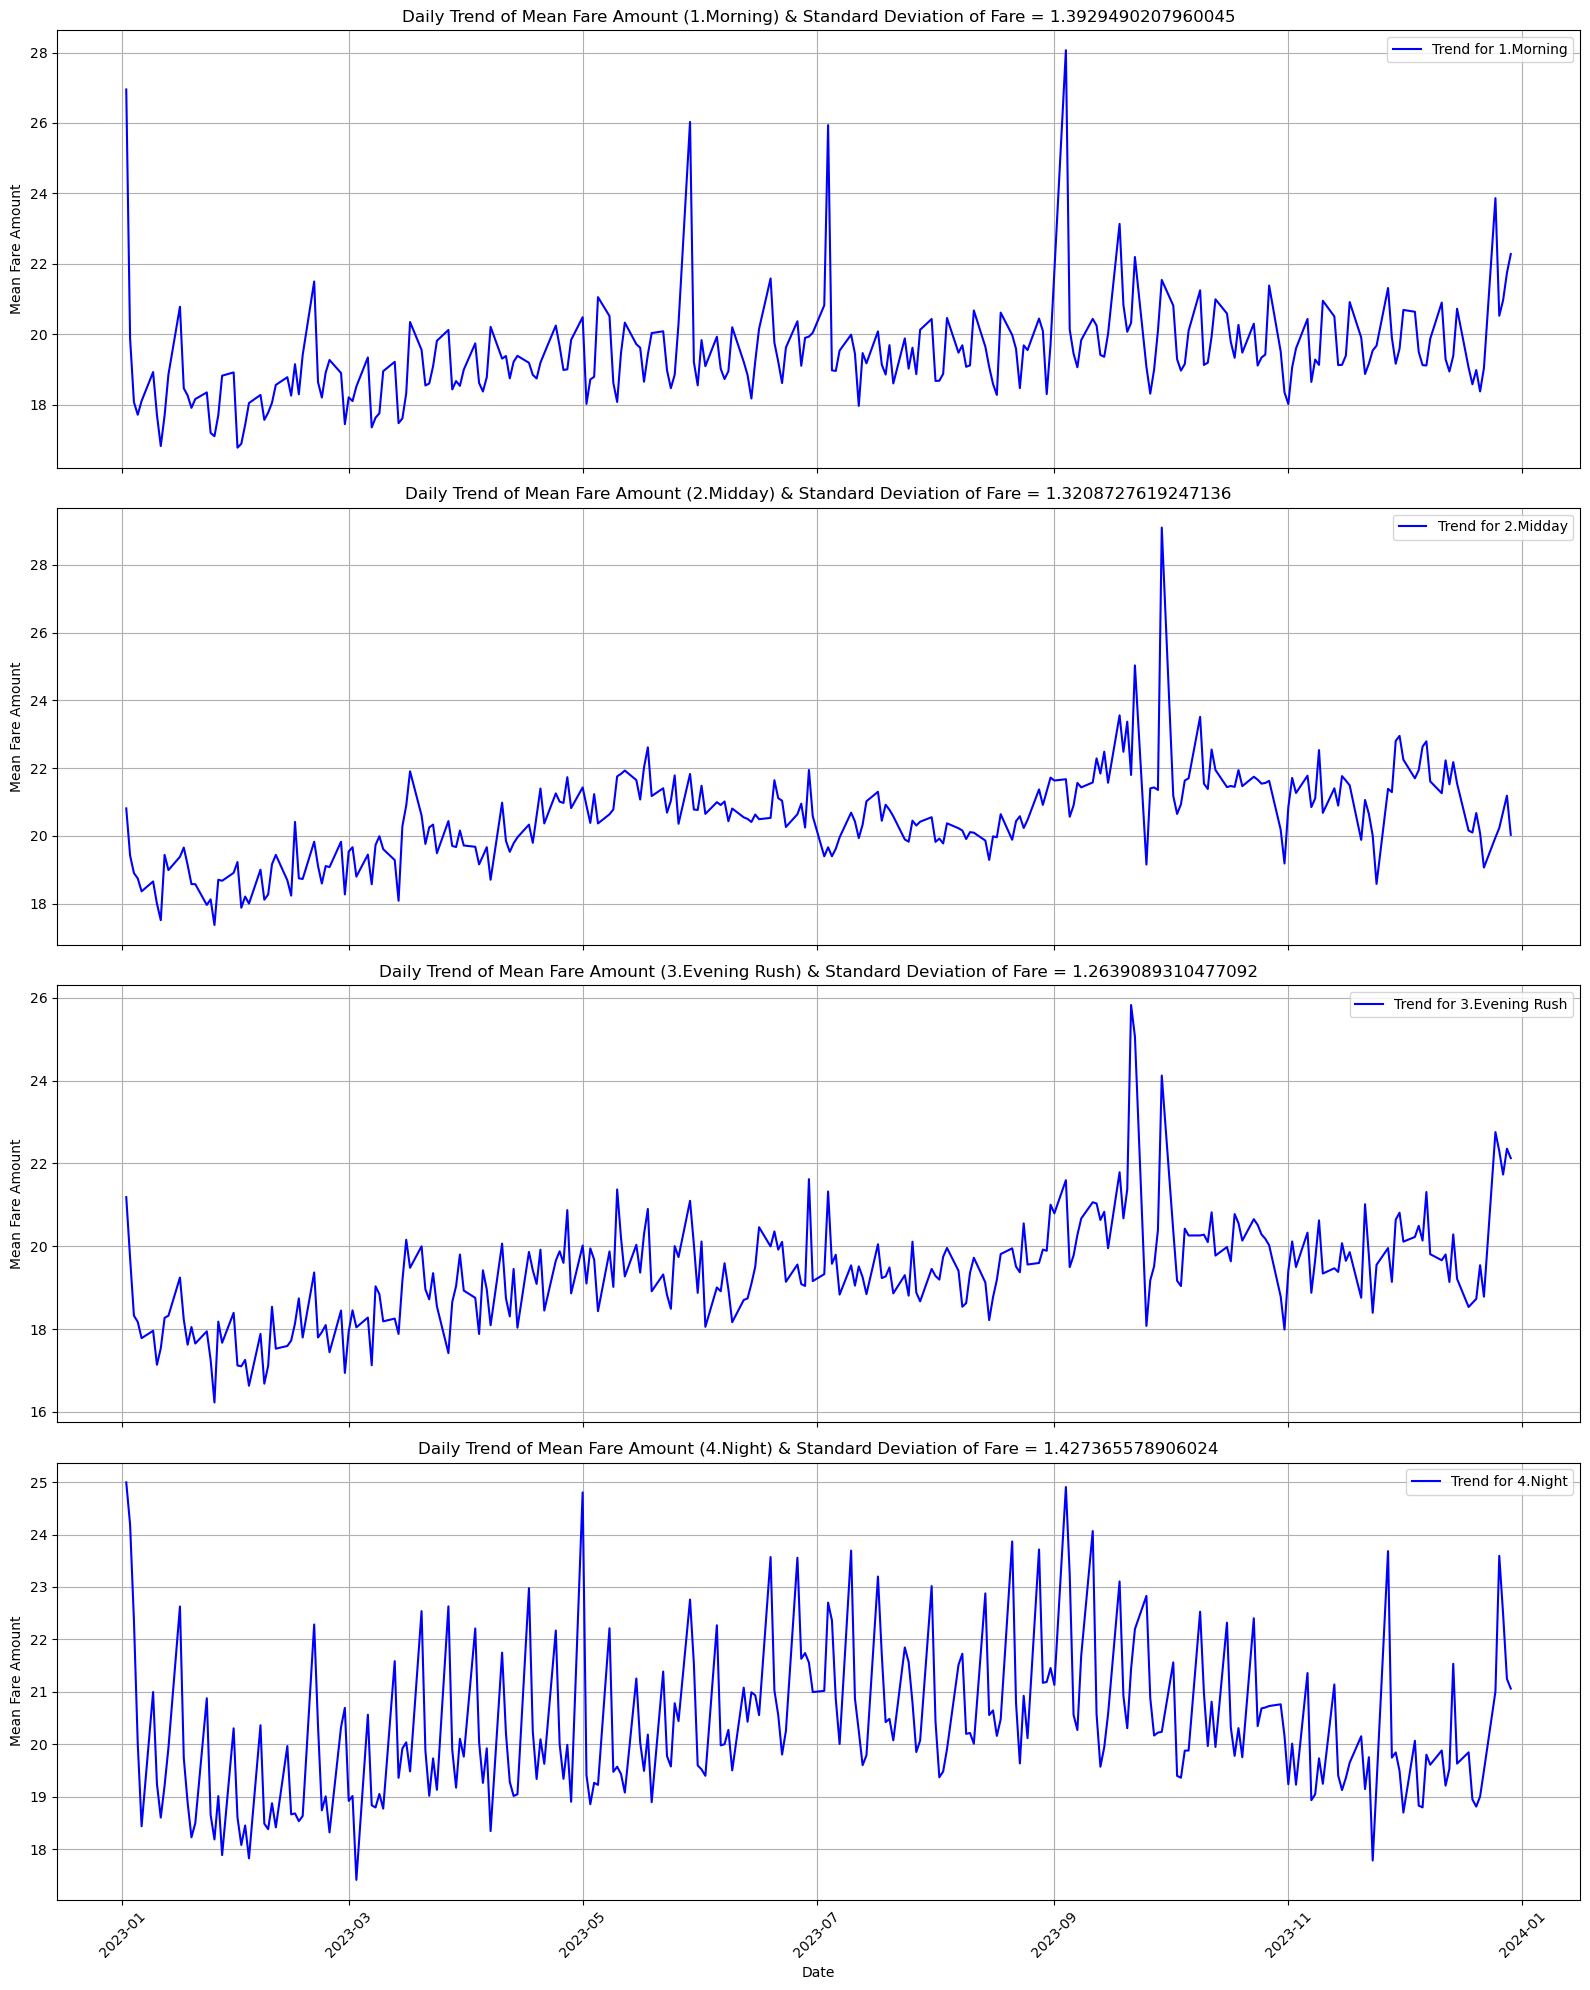

In [94]:
# Group by date and time_of_day, calculate mean fare amount
daily_mean_fare = sampled_dat[(sampled_dat['tpep_pickup_datetime'].dt.year == 2023) & (~sampled_dat['tpep_dayname'].isin(['Saturday', 'Sunday']))
].groupby(['tpep_date', 'time_of_day'])['fare_amount'].mean().reset_index()

# Create a figure with 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(16, 20), sharex=True)

# List of time blocks to iterate over
time_blocks = ['1.Morning', '2.Midday', '3.Evening Rush', '4.Night']

# Plot each time block in a separate subplot
for i, time_block in enumerate(time_blocks):
    # Filter data for the current time block
    block_data = daily_mean_fare[daily_mean_fare['time_of_day'] == time_block]
    
    std = np.std(block_data['fare_amount'])
    # Plot the trend line for the current time block
    axes[i].plot(block_data['tpep_date'], block_data['fare_amount'], label=f'Trend for {time_block}', color='blue')
    axes[i].set_title(f'Daily Trend of Mean Fare Amount ({time_block}) & Standard Deviation of Fare = {std}')
    axes[i].set_ylabel('Mean Fare Amount')
    axes[i].grid(True)
    axes[i].legend()

# Set common x-axis label
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1.Morning


/var/folders/x0/rpxk2qtn1plg19j8v45ncgb80000gn/T/ipykernel_4559/1981968312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[column] = pd.to_datetime(dat[column])


<Figure size 1000x1300 with 0 Axes>

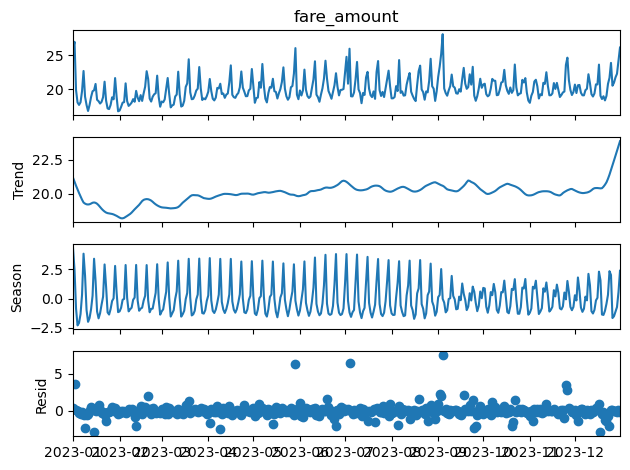

2.Midday


/var/folders/x0/rpxk2qtn1plg19j8v45ncgb80000gn/T/ipykernel_4559/1981968312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[column] = pd.to_datetime(dat[column])


<Figure size 1000x1300 with 0 Axes>

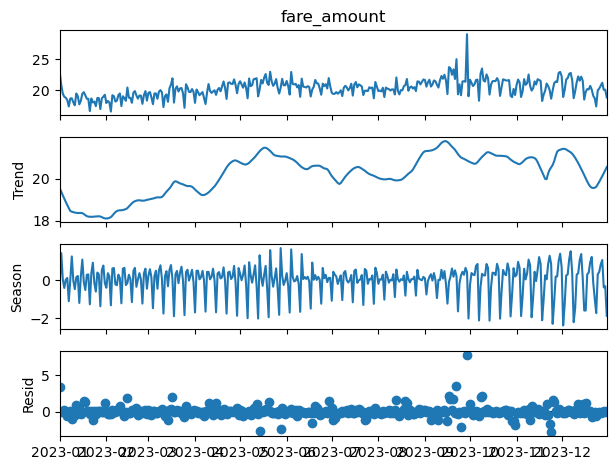

3.Evening Rush


/var/folders/x0/rpxk2qtn1plg19j8v45ncgb80000gn/T/ipykernel_4559/1981968312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[column] = pd.to_datetime(dat[column])


<Figure size 1000x1300 with 0 Axes>

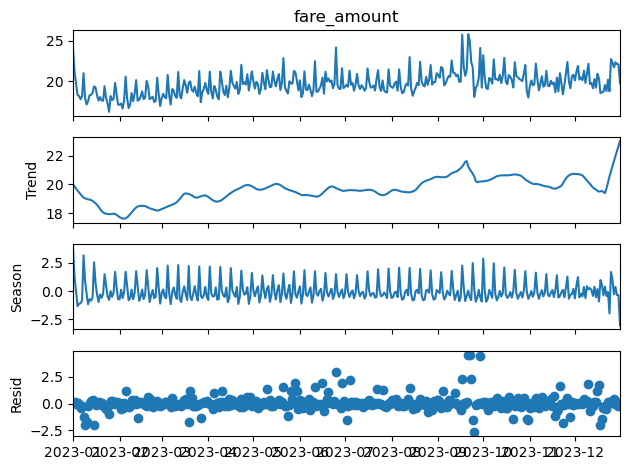

4.Night


/var/folders/x0/rpxk2qtn1plg19j8v45ncgb80000gn/T/ipykernel_4559/1981968312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[column] = pd.to_datetime(dat[column])


<Figure size 1000x1300 with 0 Axes>

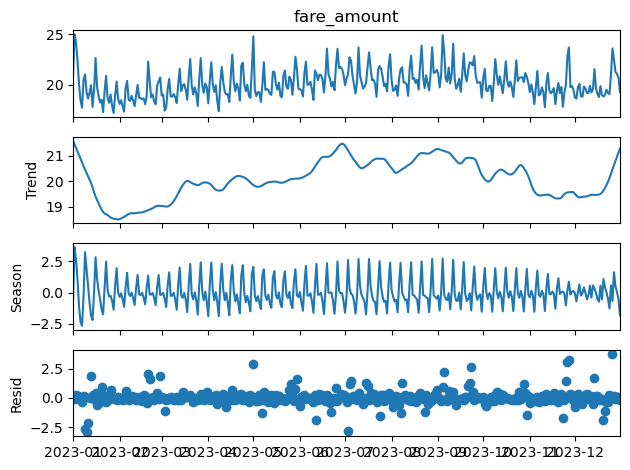

In [132]:
results = sampled_dat[(sampled_dat['tpep_pickup_datetime'].dt.year == 2023)].groupby(['tpep_date', 'time_of_day'])['fare_amount'].mean().reset_index()
time_blocks = ['1.Morning', '2.Midday', '3.Evening Rush', '4.Night']
seasonality = {}
for t in time_blocks:
    t_result = results[results['time_of_day'] == t]
    print(t)
    ts_result = decompose(t_result, 'tpep_date')
    seasonality[t] = ts_result
    
    

In [173]:
seasonality['4.Night'][:30]

tpep_date
2023-01-01   -0.681636
2023-01-02    3.640928
2023-01-03    2.655741
2023-01-04    1.018557
2023-01-05   -1.095686
2023-01-06   -2.380176
2023-01-07   -2.681242
2023-01-08   -0.326044
2023-01-09    3.238459
2023-01-10    1.868766
2023-01-11    0.571204
2023-01-12   -0.814154
2023-01-13   -1.865686
2023-01-14   -2.212529
2023-01-15    0.023229
2023-01-16    2.835646
2023-01-17    1.109548
2023-01-18    0.149512
2023-01-19   -0.526078
2023-01-20   -1.349994
2023-01-21   -1.750159
2023-01-22    0.358387
2023-01-23    2.479297
2023-01-24    0.192812
2023-01-25   -0.326046
2023-01-26   -0.266739
2023-01-27   -0.658383
2023-01-28   -1.375529
2023-01-29    0.478872
2023-01-30    1.956502
Name: season, dtype: float64